In [ ]:
#import os
#os.chdir("/mnt/c/users/ARUN GARG/Desktop/Complete-Elementor-Template-Pack-2019/facenet/")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
cd gdrive/My\ Drive/facenet

/content/gdrive/My Drive/facenet


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

import numpy as np
from PIL import Image, ImageDraw
import os
import cv2
import time

from detect_face import FaceDetector

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [ ]:
MODEL_PATH = 'pretrained_model.pb'
face_detector = FaceDetector(MODEL_PATH, gpu_memory_fraction=0.25, visible_device_list='0')

In [ ]:
path1 = 'img/image1.jpg'

image_array1 = cv2.imread(path1)
image_array1 = cv2.cvtColor(image_array1, cv2.COLOR_BGR2RGB)
image1 = Image.fromarray(image_array1)

path2 = 'img/image2.jpg'

image_array2 = cv2.imread(path2)
image_array2 = cv2.cvtColor(image_array2, cv2.COLOR_BGR2RGB)
image2 = Image.fromarray(image_array2)

In [ ]:
def draw_boxes_on_image(image, boxes, scores):

    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy, 'RGBA')
    width, height = image.size

    for b, s in zip(boxes, scores):
        ymin, xmin, ymax, xmax = b
        fill = (255, 0, 0, 45)
        outline = 'red'
        draw.rectangle(
            [(xmin, ymin), (xmax, ymax)],
            fill=fill, outline=outline
        )
        draw.text((xmin, ymin), text='{:.3f}'.format(s))
    return image_copy

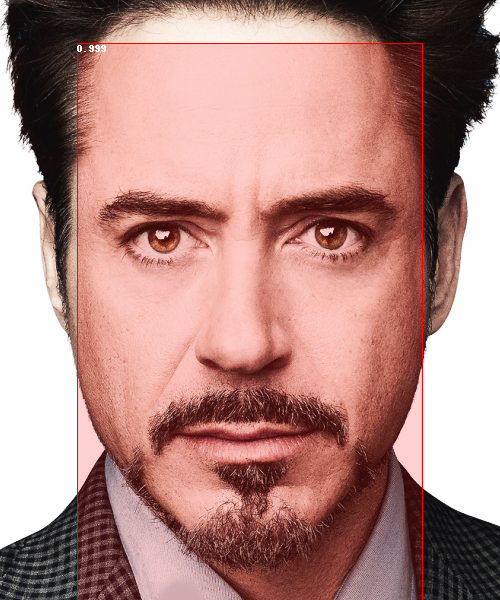

In [ ]:
#first_face_detect

boxes, scores = face_detector(image_array1, score_threshold=0.3)
draw_boxes_on_image(image1, boxes, scores)

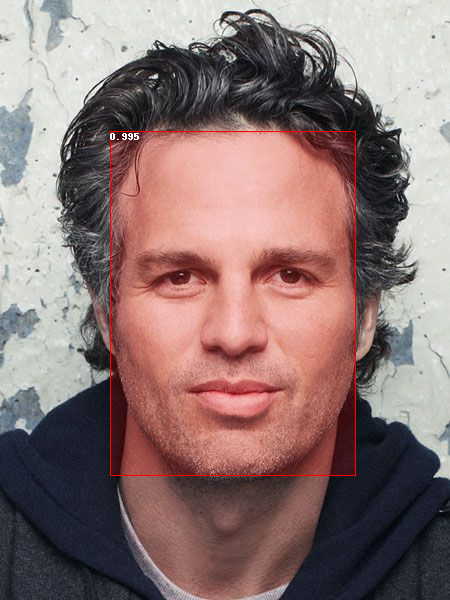

In [ ]:
#second_face_detect

boxes, scores = face_detector(image_array2, score_threshold=0.3)
draw_boxes_on_image(image2, boxes, scores)

In [ ]:
import os
import numpy as np
from PIL import Image,ImageFont,ImageDraw
import matplotlib.pyplot as plt
import cv2
from script.fx import prewhiten,l2_normalize
from keras.models import load_model
from scipy.spatial import distance

Using TensorFlow backend.


In [ ]:
model_path='data/model/facenet_keras.h5'
face_cascade_path='./data/cascade/haarcascade_frontalface_default.xml'
font_path='../data/font/Calibri Regular.ttf'
embedding_path='./data/arrays/embeddings.npz'
vars_path='./data/arrays/vars.npz'



model=load_model(model_path)
face_cascade=cv2.CascadeClassifier(face_cascade_path)
loaded_embeddings=np.load(embedding_path)
embeddings,names=loaded_embeddings['a'],loaded_embeddings['b']
loaded_vars=np.load(vars_path)
slope,intercept=loaded_vars['a'],loaded_vars['b']


os.system('cls')
print("\n\n\nKeep the images in './test/' directory.")
input("Press ENTER when you're ready.")


os.chdir('./test/')
dr=os.listdir()
dr.remove('predicted')
for c in dr:
    frame=cv2.imread(c)
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray,scaleFactor=1.2,minNeighbors=10)
    
    for (x_face,y_face,w_face,h_face) in faces:
        
        #Margins for Face box
        dw=0.1*w_face
        dh=0.2*h_face
        
        dist=[]
        for i in range(len(embeddings)):
            dist.append(distance.euclidean(l2_normalize(model.predict(prewhiten(cv2.resize(frame[y_face:y_face+h_face,x_face:x_face+w_face],(160,160)).reshape(-1,160,160,3)))),embeddings[i].reshape(1,128)))
        dist=np.array(dist)
        if dist.min()>1:
            name='Unidentified'
        else:   
            name=names[dist.argmin()]
        print(name,dist.min())
        
        if name!='Unidentified':
            font_size=int(slope[dist.argmin()]*((w_face+2*dw)//3)*2+intercept[dist.argmin()])
        else:
            font_size=int(0.1974311*((w_face+2*dw)//3)*2+0.03397702412218706)
            
        font=ImageFont.truetype(font_path,font_size)
        size=font.getsize(name)

        cv2.rectangle(frame,
                      pt1=(x_face-int(np.floor(dw)),(y_face-int(np.floor(dh)))),
                      pt2=((x_face+w_face+int(np.ceil(dw))),(y_face+h_face+int(np.ceil(dh)))),
                      color=(0,255,0),
                      thickness=2) #Face Rectangle
        
        cv2.rectangle(frame,
                      pt1=(x_face-int(np.floor(dw)),y_face-int(np.floor(dh))-size[1]),
                      pt2=(x_face-int(np.floor(dw))+size[0],y_face-int(np.floor(dh))),
                      color=(0,255,0),
                      thickness=-1) #Face Name background rectangle
        
        img=Image.fromarray(frame)
        draw=ImageDraw.Draw(img)
        draw.text((x_face-int(np.floor(dw)),y_face-int(np.floor(dh))-size[1]),name,font=font,fill=(255,0,0))
        frame=np.array(img)

    frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    plt.imsave('./predicted/'+c,frame)
print("\n\n\nOutputs can be found in './test/predicted/'")


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '





Keep the images in './test/' directory.
Press ENTER when you're ready.

Robert Downey Jr. 0.7295372486114502
Mark Ruffalo 0.9340019226074219



Outputs can be found in './test/predicted/'
